# Прогнозирование цены автомобиля Ford по его VIN-коду

В современном мире автомобильная промышленность играет важную роль в экономике многих стран. Компании, занимающиеся производством и продажей автомобилей, постоянно стремятся к повышению эффективности своей деятельности и улучшению качества обслуживания клиентов. Одним из ключевых аспектов в этом процессе является правильная оценка стоимости автомобилей.

**Цель проекта:** Цель данного проекта заключается в том, чтобы создать инструмент, который позволит определить цену на автомобиль марки Ford по его VIN-коду.

Такой подход может быть полезен для дилерских центров, аукционов по продаже подержанных автомобилей, физическому лицу и организаций, занимающихся оценкой и торговлей автомобилями. Примерная оценка стоимости транспортного средства позволит избежать завышенных или заниженных цен.

**Особенность проекта** заключается в том, что данные представленные в сыром текстовом формате, которые необходимо распарсить в структурированный вид. 

В ходе проекта выполняется процесс обработки и анализ данных, а также построение и оценка модели машинного обучения. Этот проект служит отправной точкой для дальнейших исследований и разработок в области автоматизированной оценки стоимости автомобилей на основе вин-кодов.

**Основные метрики**: `root mean squared error` и `mean absolute percentage error`.

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

import optuna


import re
import pathlib
import string
import joblib

ROOT_DIR = pathlib.Path().absolute().parent
DATA_DIR = ROOT_DIR / "vin_code" /"vin_ford_train.txt"
DATA_DIR_EXAMPLE = ROOT_DIR / "vin_code" /"vin_ford_train_example.txt"
RANDOM_STATE = 42

# Загрузка и обзор данных

Данны предоставленны в следующем формате.

In [2]:
with open(DATA_DIR_EXAMPLE, 'r', encoding='utf-8') as f:
    text_example = f.read()
text_example

'[1FTNE2EW8EDA17466:21500][1FM5K7D88DGC48613:25200][1FTWW33R58EC42270:21800][1FTFX1EF5DFB92558:20000][1FAHP35N98W236133:5400][1FM5K8F80FGA15654:33000][1FDNE1BW8BDB21610:11100][1FAHP2EWXBG188016:12300][2FMDK3GCXABB66437:9900][3FA6P0H72DR349597:11300][3FAHP0JA0CR363253:14800][1FMHK8F84CGA23300:26100][3FA6P0H74ER208774:14000][1FTBF2AT1BEA57499:12000][1FAHP3FN1AW212932:4550][1ZVBP8AMXE5222556:18100][1FMJU1H57EEF02511:31000][1FTFX1EF5DFB01255:26000][1FTYR44U64PB12702:6500][3FAHP0JG3BR225824:7600][3FAHP0HA1CR351635:8600][1FADP3F27EL307040:13600][2FMDK4JC1EBA84133:23200][1FTDX17W1VNB73890:1000][1FADP3F23DL169365:12200][3FA6P0HD2ER142859:16300][1FAHP34N76W128169:1500][1FMCU9D78AKD21749:7200]'

Нам предоставлены сырые данные автомобилей с уникальным кодом. В файле VIN-коды машин написаны по следующему шаблону: `[VIN-CODE:PRICE]`. Все, что находится вне этого шаблона, нас не интересует.

Далее приведем их в табличный вид для анализа данных и построения модели предсказания цены по VIN-коду.

In [3]:
with open(DATA_DIR, 'r', encoding='utf-8') as f:
    text = f.read()

# Предобработка VIN-кодов

VIN-коды имеют определенную позиционную структуру, содержащие символы латинского алфавита и арабские цифры. При этом запрещены следующие символы: `Q`, `I`, `O`, `1`, `0`, `9`.

Известно, что в тексте содержатся VIN-коды автомобилей марки Ford Северо-Американского производства, поэтому воспользуемся следующим форматом при его стандартизации и расшифровке.

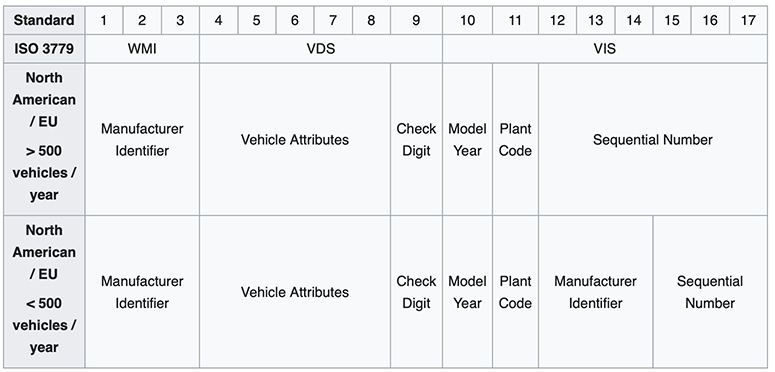

1. **WMI** (World Manufacturer Identifier) — всемирный индекс производителя. Первый символ совместно со вторым указывает на географическое положение и страну производителя. Третий знак - конкретного изготовителя (либо тип транспортного средства) или на малое производство автомобилей в год, если указана цифра `9`.
2. **VDS** (Vehicle Description Section) — описательная часть, предоставляет более подробную информацию о конкретной модели автомобиля, включая тип кузова, двигателя,  место производства и серию/модель.
3. **VIS** (Vehicle Identification Section) — указательная часть. Это серийный номер автомобиля или его порядковый номер, которое выпустило производство в течение 30 лет. Последние четыре знака должны быть цифрами.


Выполним следующие шаги для определения VIN-кодов:

1. Определим только разрешенные символы для VIN.
2. Оставим только Северо-Американский регион и автомобили Ford.
3. Приведем текстовый массив в табличный формат.

## VIN-коды в признаки

Разделим VIN-коды по секциям соответствующего формата. Каждая секция будет содержать информацию о признаке автомобиля. Преобразуем эти секции в датафрейм с целевым признаком `цена`.

### Разрешенные символы

VIN - код состоит из 17 знаков за исключением `I`, `O`, `1`, `0`, `9`.

In [4]:
allowed_letters = [letter for letter in string.ascii_uppercase if letter not in ['I', 'O', 'Q']]
allowed_digits = [str(x) for x in range(1,10)] + ['0']
allowed_chars = ''.join(allowed_letters+allowed_digits)
allowed_chars

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

В кодировке года Северо-Американского VIN кода отсутствуют следующие символы: `U` и `Z`.

In [5]:
allowed_years = allowed_chars.replace('U', '').replace('Z', '')
allowed_years

'ABCDEFGHJKLMNPRSTVWXY1234567890'

### Формат VIN кода

Разделим VIN-код в соответствии с форматом Северо-Американского стандарта.

Каждую часть VIN-кода запишем в отдельную переменную с помощью f-строк.

In [6]:
WMI_RE = f'(?P<wmi>[{allowed_chars}]{{3}})'          # Всемирный индекс производителя (WMI)
RESTRAINT_RE = f'(?P<restraint>[{allowed_chars}])'   # Система безопасности
MODEL_RE = f'(?P<model>[{allowed_chars}]{{3}})'      # Модель
ENGINE_RE = f'(?P<engine>[{allowed_chars}])'         # Двигатель
CHECK_RE = f'(?P<check>[{allowed_chars}])'           # Контрольная цифра
YEAR_RE = f'(?P<year>[{allowed_years}])'             # Год
PLANT_RE = f'(?P<plant>[{allowed_chars}])'           # Завод иготовитель
VIS_RE = f'(?P<vis>[{allowed_chars}]{{3}}\\d{{3}})'  # Серийный номер
PRICE_RE = f':(?P<price>\\d+)'                       # Цена в долларах

In [7]:
vin_full = f'\\b{WMI_RE}{RESTRAINT_RE}{MODEL_RE}{ENGINE_RE}{CHECK_RE}{YEAR_RE}{PLANT_RE}{VIS_RE}{PRICE_RE}\\b'
vin_re = re.compile(vin_full)

In [8]:
def decode_vin(s: str) -> pd.DataFrame:
     return pd.DataFrame([x.groupdict() for x in vin_re.finditer(s)])

In [9]:
data_raw = decode_vin(text)
data_raw

,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600
...,...,...,...,...,...,...,...,...,...
71879,1FT,D,X17,W,1,V,N,B73890,1000
71880,1FA,D,P3F,2,3,D,L,169365,12200
71881,3FA,6,P0H,D,2,E,R,142859,16300
71882,1FA,H,P34,N,7,6,W,128169,1500


# Предобработка датафрейма

Выведем информацию о данных.

In [10]:
data = data_raw.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


По данным:

* 71885 VIN-кодов (автомобилей);
* необходимо преобразовать цену в тип `int`;
* признак `vis` является уникальным идентификатором, поэтому его отбросим, чтобы не допустить утечку данных.

In [11]:
data = data.drop('vis', axis=1)
data.head()

,wmi,restraint,model,engine,check,year,plant,price
0,2FM,D,K3J,C,4,B,B,12500
1,3FA,6,P0H,7,5,E,R,14500
2,3FA,H,P08,Z,1,7,R,1300
3,1FM,C,U0G,X,3,D,U,15200
4,1FA,H,P2E,8,9,D,G,11600


In [12]:
data['price'] = data['price'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   price      71884 non-null  int32 
dtypes: int32(1), object(7)
memory usage: 4.1+ MB


In [13]:
# проверим на наличие пропусков
data.isna().sum()

wmi          0
restraint    0
model        0
engine       0
check        0
year         0
plant        0
price        0
dtype: int64

Данные готовы для анализа.

Итоговой датафрейм

In [14]:
data

,wmi,restraint,model,engine,check,year,plant,price
0,2FM,D,K3J,C,4,B,B,12500
1,3FA,6,P0H,7,5,E,R,14500
2,3FA,H,P08,Z,1,7,R,1300
3,1FM,C,U0G,X,3,D,U,15200
4,1FA,H,P2E,8,9,D,G,11600
...,...,...,...,...,...,...,...,...
71879,1FT,D,X17,W,1,V,N,1000
71880,1FA,D,P3F,2,3,D,L,12200
71881,3FA,6,P0H,D,2,E,R,16300
71882,1FA,H,P34,N,7,6,W,1500


# Анализ данных

## Распределение цен

In [15]:
data['price'].describe().astype('int')

count    71884
mean     14321
std       7827
min       1000
25%       8800
50%      13500
75%      19500
max      36500
Name: price, dtype: int32

Из данных видно, что диапозон цен довольно большой (минимальная цена - 1000 долл., максимальная цена - 36500 долл.)

Посмотрим на распределение на графиках.

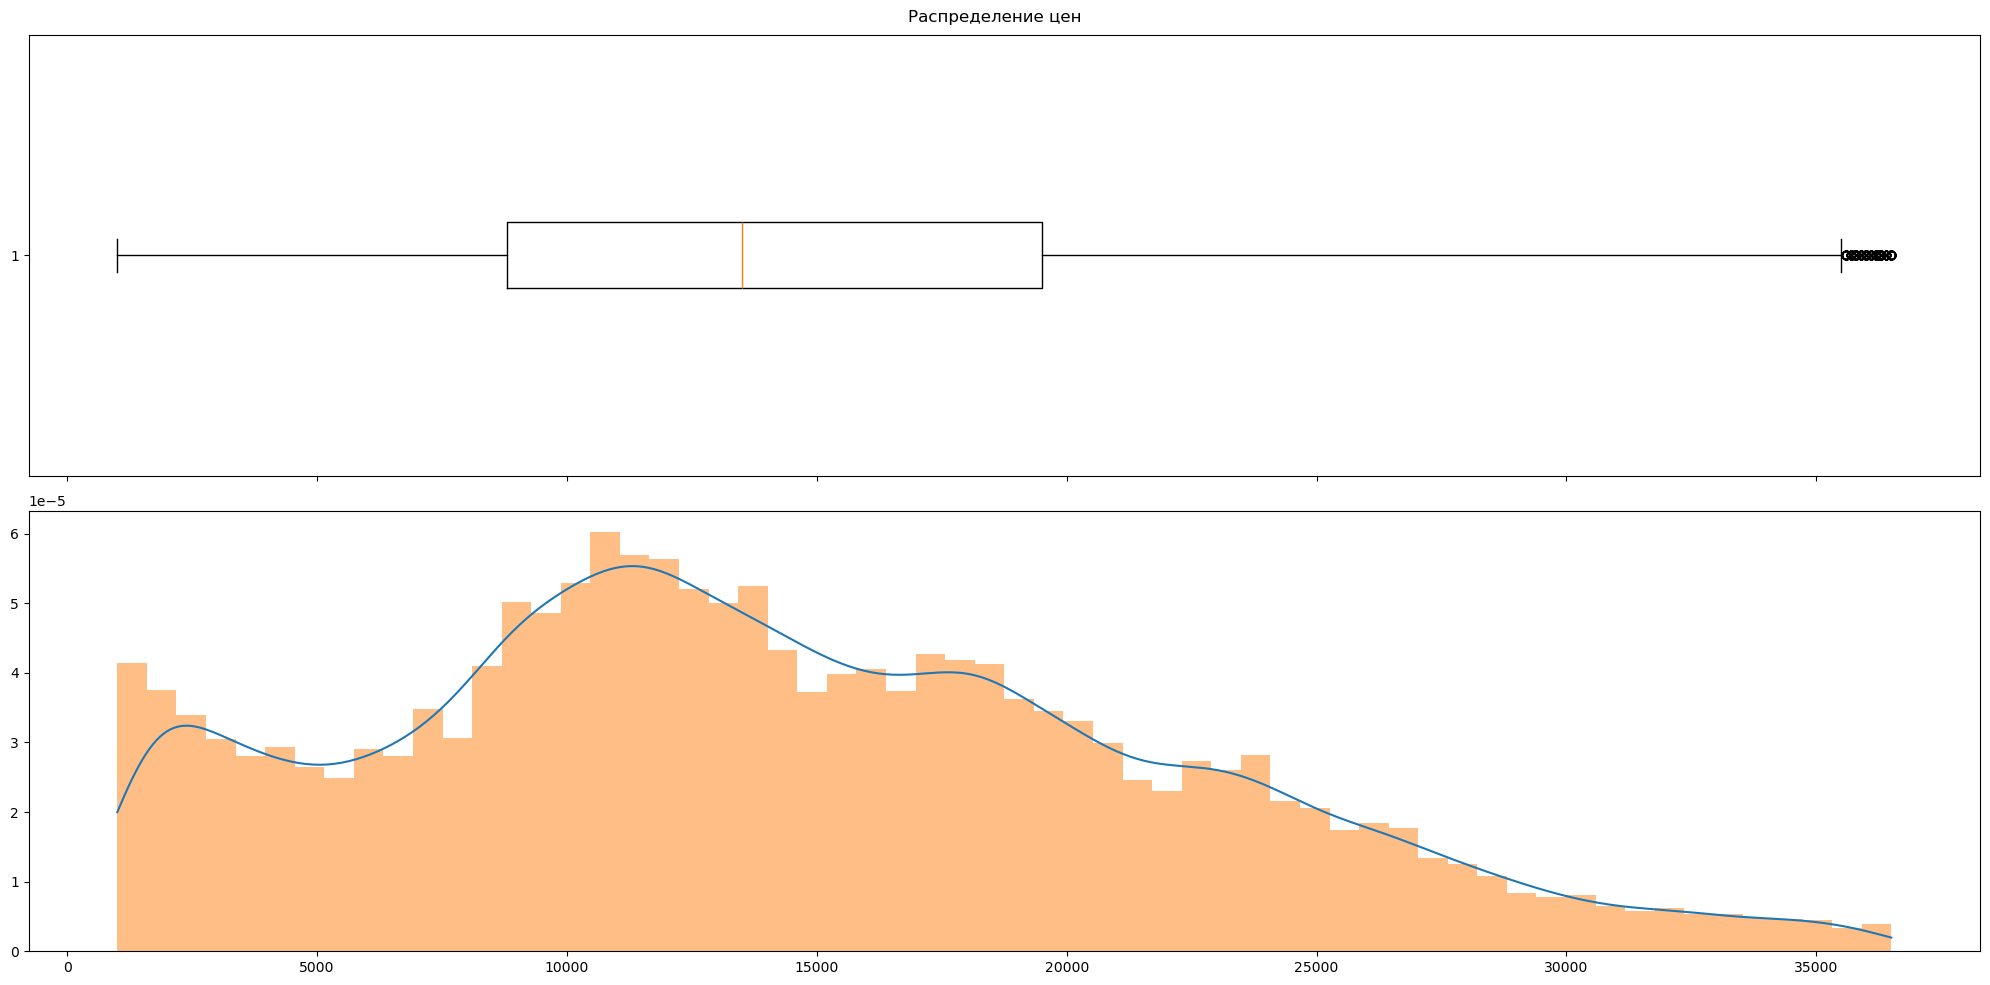

In [16]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True)

kde = gaussian_kde(data['price'])
kde_x = np.linspace(data['price'].min(), data['price'].max(), 500)

ax[0].boxplot(data['price'],vert=False)

kde_y = kde(kde_x)

ax[1].plot(kde_x, kde_y, label='KDE')
ax[1].hist(data['price'], bins=60, alpha=0.5, density=True)

plt.suptitle('Распределение цен')
plt.tight_layout()
plt.show()

* наибольшее количество автомобилей в ценовом диапозоне от 7 тыс. до 14 тыс;
* после цены 17 тыс. количество авто постепенно уменьшается.

Посмотрим сколько предложений с ценой более 35000. На диаграмме размаха они выделены как выбросы.

In [17]:
data.query('price > 35000')

,wmi,restraint,model,engine,check,year,plant,price
21,1FM,J,K1J,5,6,E,E,36300
199,1FT,F,W1E,F,6,D,K,35200
298,1FM,5,K8G,T,1,D,G,35400
329,1FT,F,W1E,T,2,E,K,35250
545,1FM,J,K1J,5,3,E,E,36100
...,...,...,...,...,...,...,...,...
71215,1FT,F,W1E,T,3,D,F,36500
71240,1FT,F,W1E,F,X,D,F,35400
71563,1FM,5,K8G,T,8,E,G,35500
71642,1FM,J,K2A,5,4,E,E,35500


В этой категории находятся спортивные внедорожники и пикапы, поэтому цена такая высокая. Для лучшей обобщающей способности модели было решено оставить эти данные.

# Подготовка выборок

Разделим выборки с помощью метода `train_test_split` из бибилотеки `scikit-learn` в соотношении 3:1.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('price',axis=1), 
    data['price'], 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

In [19]:
# выделим признаки в категориальные переменные, это понадобится при построении модели
cat_features = list(X_train.select_dtypes(include='object').columns)
cat_features

['wmi', 'restraint', 'model', 'engine', 'check', 'year', 'plant']

# Построение модели

Воспользуемся `CatBoostRegressor` в качестве модели предсказания.

In [20]:
# запишем в словарь гиперпараметры
params = {'learning_rate': 0.055, 
          'depth': 10, 
          'subsample': 1, 
          'colsample_bylevel': 0.75, 
          'min_data_in_leaf': 32}

In [21]:
model = CatBoostRegressor(**params, cat_features=cat_features, random_state=RANDOM_STATE)

In [ ]:
model.fit(X_train, y_train, silent=True);

In [ ]:
predictions = model.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, predictions)**0.5
mape = mean_absolute_percentage_error(y_test, predictions)
print('Корень из средней квадратичной ошибки:', rmse.round(2))
print('Средняя абсолютная процентная ошибка:', mape.round(3)*100)

# Константная модель

Проверим адекватность результата обученной модели, вычислив результат константной.

In [ ]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

In [ ]:
rmse_dummy = mean_squared_error(y_test, dummy_pred)**0.5
print('Корень из средней квадратичной ошибки:', rmse_dummy.round(2))

Константная модель справляется намного хуже.

# Класс предсказания

In [ ]:
# сохраним модель
filename = 'final_model.sav'
joblib.dump(model, filename)

In [ ]:
class VINPricePredictor:
    def __init__(self, model_path):
        self.vin_pattern = f'\\b{WMI_RE}{RESTRAINT_RE}{MODEL_RE}{ENGINE_RE}{CHECK_RE}{YEAR_RE}{PLANT_RE}{VIS_RE}\\b'
        self.model = joblib.load(model_path)

    def vin_to_features(self, vin):
        self.vin_re = re.compile(self.vin_pattern)
        self.features = pd.DataFrame([x.groupdict() for x in self.vin_re.finditer(vin)])
        return self.features
        
    def predict_price(self, vin):
        self.cleaned_features = self.features.drop('vis', axis=1)
        predicted_price = int(self.model.predict(self.cleaned_features)[0])
        
        return f"Предсказанная цена: {predicted_price} долларов"

In [ ]:
# пример использования
example_vin = '1FTNE2EW5EDA10328'

predictor = VINPricePredictor(ROOT_DIR/'vin_code'/'final_model.sav') # указать путь к сохраненной модели
predictor.vin_to_features(example_vin)
predictor.predict_price(example_vin)

# Итоговый вывод

В ходе исследования были выполнены следующие шаги:

1. Ознакомились с предоставленными текстовыми данными VIN-кодов и соответствующей им цены.
2. Выполнили форматирование VIN-кодов в датафрейм с признаками соответствующими Северо-Американским стандартом.
3. Провели предобработку полученного датафрейма.
4. Выполнили анализ данных.
5. Подготовили выборки для обучения модели.
6. Сравнили результаты с константной моделью.

Метрики полученной модели: `RMSE` = 2785, `MAPE` = 20.4%

Метрика константной модели: `RMSE` = 7839

Как итог написали `class` для предсказания цены по указанному VIN-коду. Полученный инструмент можно использовать как примерный указатель цены на автомобиль Ford.